In [4]:
# Repetition Counter 실험
import pandas as pd
import numpy as np
df = pd.read_csv("/workspace/nas203/ds_RehabilitationMedicineData/IDs/Kimjihoo/ASAN_01_Repeatition_Counter/data/metadata.csv")

# 각 컬럼의 True/False 개수 세기
columns_to_check = ['frames_done', 'sapiens_done', 'reextract_done', 'overlay_done']

print("=" * 60)
for col in columns_to_check:
    print(f"\n{col}:")
    print("-" * 40)
    counts = df[col].value_counts()
    for value, count in counts.items():
        print(f"  {value}: {count}")
    print(f"  Total: {len(df)}")

print("\n" + "=" * 60)

# 요약 테이블
print("\n요약 테이블:")
print("-" * 60)
summary = pd.DataFrame({
    col: df[col].value_counts() for col in columns_to_check
}).T.fillna(0).astype(int)
print(summary)


frames_done:
----------------------------------------
  True: 1152
  Total: 1152

sapiens_done:
----------------------------------------
  True: 1152
  Total: 1152

reextract_done:
----------------------------------------
  True: 1152
  Total: 1152

overlay_done:
----------------------------------------
  True: 1152
  Total: 1152


요약 테이블:
------------------------------------------------------------
                True
frames_done     1152
sapiens_done    1152
reextract_done  1152
overlay_done    1152


Total training samples: 83
Testing with first sample...
Sample JSON path: /workspace/nas203/ds_RehabilitationMedicineData/IDs/Kimjihoo/3_project_HCCmove/data/4_INTERP_DATA/AI_dataset/N01/N01_Treatment/diagonal__hip_extension
  Loaded 320 frames from diagonal__hip_extension

✓ Loaded 320 frames

First frame structure:
  Type: dict
  Keys: ['frame_index', 'meta_info', 'instance_info']
    'instance_info': list with 1 elements

Testing different joints and axes...

--- Right Wrist - Vertical ---
  Loaded 320 frames from diagonal__hip_extension
✓ Detected 0 repetitions

--- Left Wrist - Vertical ---
  Loaded 320 frames from diagonal__hip_extension
✓ Detected 0 repetitions

--- Right Knee - Vertical ---
  Loaded 320 frames from diagonal__hip_extension
✓ Detected 0 repetitions

--- Left Knee - Vertical ---
  Loaded 320 frames from diagonal__hip_extension
✓ Detected 0 repetitions

Process all training videos? (y/n)

Processing 2/83
Video: diagonal__hip_extension.mp4
  Loaded 320 frames from d

IndexError: arrays used as indices must be of integer (or boolean) type

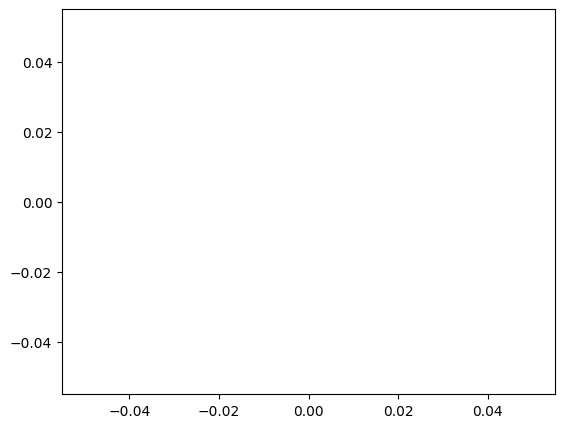

In [6]:
import pandas as pd
import numpy as np
import json
from pathlib import Path
from scipy.signal import find_peaks
import matplotlib.pyplot as plt
import os

# 1. 메타데이터 로드 및 필터링
df = pd.read_csv("/workspace/nas203/ds_RehabilitationMedicineData/IDs/Kimjihoo/ASAN_01_Repeatition_Counter/data/metadata.csv")
train_df = df[df['is_train'] == True].copy()

print(f"Total training samples: {len(train_df)}")

# 2. 디렉토리에서 JSON 파일들 읽기 함수
def load_keypoints_from_directory(json_dir):
    """
    디렉토리 내의 모든 JSON 파일을 로드하여 프레임 시퀀스로 반환
    """
    try:
        json_path = Path(json_dir)
        
        if not json_path.exists():
            print(f"Path does not exist: {json_dir}")
            return None
        
        if json_path.is_file():
            # 단일 파일인 경우
            with open(json_path, 'r') as f:
                data = json.load(f)
            return [data] if isinstance(data, dict) else data
        
        # 디렉토리인 경우: 모든 JSON 파일 읽기
        json_files = sorted([f for f in json_path.glob('*.json')])
        
        if len(json_files) == 0:
            print(f"No JSON files found in: {json_dir}")
            return None
        
        keypoints_sequence = []
        for json_file in json_files:
            try:
                with open(json_file, 'r') as f:
                    frame_data = json.load(f)
                keypoints_sequence.append(frame_data)
            except Exception as e:
                print(f"Error loading {json_file}: {e}")
                keypoints_sequence.append(None)
        
        print(f"  Loaded {len(keypoints_sequence)} frames from {json_path.name}")
        return keypoints_sequence
        
    except Exception as e:
        print(f"Error loading from {json_dir}: {e}")
        return None

# 3. Keypoints 추출 함수 (JSON 구조에 맞게 조정)
def extract_keypoint_from_frame(frame_data, joint_idx=10):
    """
    단일 프레임 데이터에서 특정 관절의 x, y 좌표 추출
    """
    if frame_data is None:
        return None, None, 0.0
    
    # 가능한 JSON 구조들 처리
    kpts = None
    confidence = 0.0
    
    if isinstance(frame_data, dict):
        # 구조 1: {'keypoints': [...]}
        if 'keypoints' in frame_data:
            kpts = frame_data['keypoints']
        # 구조 2: {'people': [{'pose_keypoints_2d': [...]}]}
        elif 'people' in frame_data and len(frame_data['people']) > 0:
            kpts = frame_data['people'][0].get('pose_keypoints_2d', None)
        # 구조 3: {'pose_keypoints_2d': [...]}
        elif 'pose_keypoints_2d' in frame_data:
            kpts = frame_data['pose_keypoints_2d']
        # 구조 4: 다른 가능한 키들
        else:
            # 첫 번째 리스트 형태의 값 찾기
            for key, value in frame_data.items():
                if isinstance(value, list) and len(value) > 30:  # keypoints는 보통 51개 이상
                    kpts = value
                    break
    elif isinstance(frame_data, list):
        kpts = frame_data
    
    if kpts is not None and len(kpts) > joint_idx * 3 + 2:
        x = kpts[joint_idx * 3]
        y = kpts[joint_idx * 3 + 1]
        confidence = kpts[joint_idx * 3 + 2] if len(kpts) > joint_idx * 3 + 2 else 1.0
        return x, y, confidence
    
    return None, None, 0.0

# 4. Repetition Counting 함수
def count_repetitions(keypoints_sequence, joint_idx=10, axis='y', 
                      height=None, distance=20, prominence=0.5):
    """
    keypoints의 특정 관절 움직임으로 repetition 카운트
    """
    signal = []
    confidences = []
    
    for frame_data in keypoints_sequence:
        x, y, conf = extract_keypoint_from_frame(frame_data, joint_idx)
        
        if x is not None and y is not None:
            value = y if axis == 'y' else x
            signal.append(value)
            confidences.append(conf)
        else:
            signal.append(np.nan)
            confidences.append(0.0)
    
    signal = np.array(signal)
    confidences = np.array(confidences)
    
    # 신뢰도가 낮은 프레임 필터링
    low_conf_mask = confidences < 0.3
    signal[low_conf_mask] = np.nan
    
    # NaN 처리 (interpolation)
    valid_idx = ~np.isnan(signal)
    if np.sum(valid_idx) < 10:  # 너무 적은 유효 프레임
        return 0, signal, np.array([])
    
    signal_interp = np.interp(
        np.arange(len(signal)), 
        np.arange(len(signal))[valid_idx], 
        signal[valid_idx]
    )
    
    # 신호 스무딩 (노이즈 제거)
    from scipy.ndimage import gaussian_filter1d
    signal_smooth = gaussian_filter1d(signal_interp, sigma=2)
    
    # 신호 정규화
    signal_norm = (signal_smooth - np.mean(signal_smooth)) / (np.std(signal_smooth) + 1e-8)
    
    # 피크 감지 (양방향)
    peaks_max, properties_max = find_peaks(
        signal_norm, 
        height=height, 
        distance=distance, 
        prominence=prominence
    )
    peaks_min, properties_min = find_peaks(
        -signal_norm, 
        height=height, 
        distance=distance, 
        prominence=prominence
    )
    
    # 더 많은 피크를 가진 쪽 선택
    if len(peaks_max) >= len(peaks_min):
        reps = len(peaks_max)
        peaks = peaks_max
    else:
        reps = len(peaks_min)
        peaks = peaks_min
    
    return reps, signal_norm, peaks

# 5. 단일 비디오 처리 함수
def process_single_video(row, joint_idx=10, axis='y'):
    """
    하나의 비디오에 대해 repetition counting 수행
    """
    json_path = row['interp_json_path']
    
    if pd.isna(json_path):
        return None
    
    # JSON 로드 (디렉토리 또는 파일)
    keypoints_sequence = load_keypoints_from_directory(json_path)
    if keypoints_sequence is None or len(keypoints_sequence) == 0:
        return None
    
    # Repetition counting
    reps, signal, peaks = count_repetitions(
        keypoints_sequence, 
        joint_idx=joint_idx, 
        axis=axis,
        distance=20,
        prominence=0.5
    )
    
    result = {
        'video_path': row['video_path'],
        'json_path': json_path,
        'n_frames': row['n_frames'],
        'detected_reps': reps,
        'signal_length': len(signal),
        'peaks': peaks.tolist() if len(peaks) > 0 else []
    }
    
    return result, signal, peaks

# 6. 시각화 함수
def plot_repetition_count(signal, peaks, title="Repetition Counting"):
    """
    신호와 감지된 피크를 시각화
    """
    plt.figure(figsize=(14, 5))
    
    # 서브플롯 1: 전체 신호
    plt.subplot(1, 2, 1)
    plt.plot(signal, label='Joint Position Signal', linewidth=2, alpha=0.7)
    plt.plot(peaks, signal[peaks], 'ro', markersize=10, label=f'Peaks (n={len(peaks)})')
    plt.xlabel('Frame', fontsize=12)
    plt.ylabel('Normalized Position', fontsize=12)
    plt.title(title, fontsize=14, fontweight='bold')
    plt.legend(fontsize=10)
    plt.grid(True, alpha=0.3)
    
    # 서브플롯 2: 피크 간격 분포
    if len(peaks) > 1:
        plt.subplot(1, 2, 2)
        peak_intervals = np.diff(peaks)
        plt.hist(peak_intervals, bins=15, color='skyblue', edgecolor='black')
        plt.xlabel('Frames between peaks', fontsize=12)
        plt.ylabel('Count', fontsize=12)
        plt.title(f'Peak Interval Distribution\nMean: {peak_intervals.mean():.1f} frames', 
                  fontsize=12)
        plt.grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    return plt.gcf()

# 7. 전체 데이터셋 처리
def process_all_videos(train_df, joint_idx=10, axis='y', visualize_first_n=5):
    """
    모든 training 비디오에 대해 repetition counting
    """
    results = []
    
    for idx, row in train_df.iterrows():
        print(f"\n{'='*60}")
        print(f"Processing {idx+1}/{len(train_df)}")
        print(f"Video: {Path(row['video_path']).name if pd.notna(row['video_path']) else 'N/A'}")
        print(f"{'='*60}")
        
        result = process_single_video(row, joint_idx=joint_idx, axis=axis)
        
        if result is not None:
            result_dict, signal, peaks = result
            results.append(result_dict)
            
            print(f"✓ Frames: {result_dict['n_frames']}")
            print(f"✓ Signal length: {result_dict['signal_length']}")
            print(f"✓ Detected repetitions: {result_dict['detected_reps']}")
            
            # 처음 몇 개 시각화
            if len(results) <= visualize_first_n:
                video_name = Path(row['video_path']).name if pd.notna(row['video_path']) else f"Sample_{idx+1}"
                fig = plot_repetition_count(
                    signal, peaks, 
                    title=f"Video {idx+1}: {video_name}"
                )
                plt.savefig(f'repetition_plot_{idx+1}.png', dpi=100, bbox_inches='tight')
                plt.show()
        else:
            print(f"✗ Failed to process")
    
    # 결과를 DataFrame으로
    results_df = pd.DataFrame(results)
    return results_df

# 8. 실행
if __name__ == "__main__":
    # 먼저 한 개 샘플로 테스트
    print("=" * 60)
    print("Testing with first sample...")
    print("=" * 60)
    
    if len(train_df) > 0:
        first_row = train_df.iloc[0]
        print(f"Sample JSON path: {first_row['interp_json_path']}")
        
        # JSON 구조 확인
        keypoints_seq = load_keypoints_from_directory(first_row['interp_json_path'])
        if keypoints_seq is not None and len(keypoints_seq) > 0:
            print(f"\n✓ Loaded {len(keypoints_seq)} frames")
            print(f"\nFirst frame structure:")
            first_frame = keypoints_seq[0]
            if isinstance(first_frame, dict):
                print(f"  Type: dict")
                print(f"  Keys: {list(first_frame.keys())}")
                # 키포인트 개수 확인
                for key in first_frame.keys():
                    if isinstance(first_frame[key], list):
                        print(f"    '{key}': list with {len(first_frame[key])} elements")
            elif isinstance(first_frame, list):
                print(f"  Type: list with {len(first_frame)} elements")
        
        # Repetition counting 테스트
        # 관절 인덱스 (COCO format 기준):
        # 0: nose, 1-2: eyes, 3-4: ears, 5-6: shoulders
        # 7-8: elbows, 9-10: wrists, 11-12: hips
        # 13-14: knees, 15-16: ankles
        
        print("\n" + "=" * 60)
        print("Testing different joints and axes...")
        print("=" * 60)
        
        # 여러 관절과 축 조합 테스트
        test_configs = [
            (10, 'y', 'Right Wrist - Vertical'),
            (9, 'y', 'Left Wrist - Vertical'),
            (14, 'y', 'Right Knee - Vertical'),
            (13, 'y', 'Left Knee - Vertical'),
        ]
        
        for joint_idx, axis, label in test_configs:
            print(f"\n--- {label} ---")
            result = process_single_video(first_row, joint_idx=joint_idx, axis=axis)
            
            if result is not None:
                result_dict, signal, peaks = result
                print(f"✓ Detected {result_dict['detected_reps']} repetitions")
                
                if result_dict['detected_reps'] > 0:
                    plot_repetition_count(signal, peaks, title=f"{label}")
                    plt.show()
    
    # 전체 처리 (원하는 경우 주석 해제)
    print("\n" + "=" * 60)
    print("Process all training videos? (y/n)")
    print("=" * 60)
    # process_all = input().lower() == 'y'
    process_all = True  # 자동 실행하려면 True로 변경
    
    if process_all:
        # 가장 적절한 관절과 축 선택 (예: 손목의 수직 움직임)
        results_df = process_all_videos(train_df, joint_idx=10, axis='y', visualize_first_n=5)
        
        if len(results_df) > 0:
            print("\n" + "=" * 60)
            print("RESULTS SUMMARY")
            print("=" * 60)
            print(results_df[['video_path', 'n_frames', 'detected_reps']].head(10))
            print("\nStatistics:")
            print(results_df['detected_reps'].describe())
            
            # 저장
            results_df.to_csv('repetition_counting_results.csv', index=False)
            print("\n✓ Results saved to 'repetition_counting_results.csv'")